In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5
DATA_DIR = "D:\my notebook\AIH\Skin Dieseas Detection"

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Important for prediction alignment
)

class_labels = list(train_generator.class_indices.keys())

Found 9108 images belonging to 5 classes.
Found 2274 images belonging to 5 classes.


#ResNet

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [6]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True)

In [7]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

Epoch 1/15
285/285 [==============================] - 118s 379ms/step - loss: 1.7805 - accuracy: 0.2034 - val_loss: 1.5981 - val_accuracy: 0.3281 - lr: 1.0000e-04
Epoch 2/15
285/285 [==============================] - 108s 378ms/step - loss: 1.6984 - accuracy: 0.2060 - val_loss: 1.5976 - val_accuracy: 0.2405 - lr: 1.0000e-04
Epoch 3/15
285/285 [==============================] - 161s 564ms/step - loss: 1.6647 - accuracy: 0.2053 - val_loss: 1.5936 - val_accuracy: 0.3588 - lr: 1.0000e-04
Epoch 4/15
285/285 [==============================] - 152s 533ms/step - loss: 1.6326 - accuracy: 0.2235 - val_loss: 1.5928 - val_accuracy: 0.2564 - lr: 1.0000e-04
Epoch 5/15
285/285 [==============================] - 97s 340ms/step - loss: 1.6149 - accuracy: 0.2331 - val_loss: 1.5902 - val_accuracy: 0.2854 - lr: 1.0000e-04
Epoch 6/15
285/285 [==============================] - 99s 348ms/step - loss: 1.6111 - accuracy: 0.2294 - val_loss: 1.5888 - val_accuracy: 0.2221 - lr: 1.0000e-04
Epoch 7/15
285/285 [====

In [8]:
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Unfreeze last 30 layers only
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/10
285/285 [==============================] - 102s 344ms/step - loss: 1.3025 - accuracy: 0.5415 - val_loss: 1.5254 - val_accuracy: 0.3826 - lr: 1.0000e-05
Epoch 2/10
285/285 [==============================] - 96s 337ms/step - loss: 0.7258 - accuracy: 0.7049 - val_loss: 1.0311 - val_accuracy: 0.5493 - lr: 1.0000e-05
Epoch 3/10
285/285 [==============================] - 97s 340ms/step - loss: 0.6299 - accuracy: 0.7452 - val_loss: 0.9451 - val_accuracy: 0.6271 - lr: 1.0000e-05
Epoch 4/10
285/285 [==============================] - 96s 336ms/step - loss: 0.5715 - accuracy: 0.7725 - val_loss: 1.1460 - val_accuracy: 0.6310 - lr: 1.0000e-05
Epoch 5/10
285/285 [==============================] - 96s 337ms/step - loss: 0.5055 - accuracy: 0.7996 - val_loss: 1.4223 - val_accuracy: 0.5501 - lr: 1.0000e-05
Epoch 6/10
285/285 [==============================] - 98s 343ms/step - loss: 0.4643 - accuracy: 0.8158 - val_loss: 2.6939 - val_accuracy: 0.3852 - lr: 1.0000e-05
Epoch 7/10
285/285 [=======

In [9]:
val_generator.reset()
preds = model.predict(val_generator)
val_preds = np.argmax(preds, axis=1)
val_true = val_generator.classes

72/72 [==============================] - 52s 697ms/step


In [10]:
print("\nClassification Report:")
print(classification_report(val_true, val_preds, target_names=class_labels))


Classification Report:
                   precision    recall  f1-score   support

           Eczema       0.97      0.96      0.97       476
      Skin Cancer       1.00      0.78      0.88       459
         Vitiligo       0.44      0.87      0.59       460
             acne       0.89      0.43      0.58       459
hyperpigmentation       0.79      0.61      0.69       420

         accuracy                           0.73      2274
        macro avg       0.82      0.73      0.74      2274
     weighted avg       0.82      0.73      0.74      2274



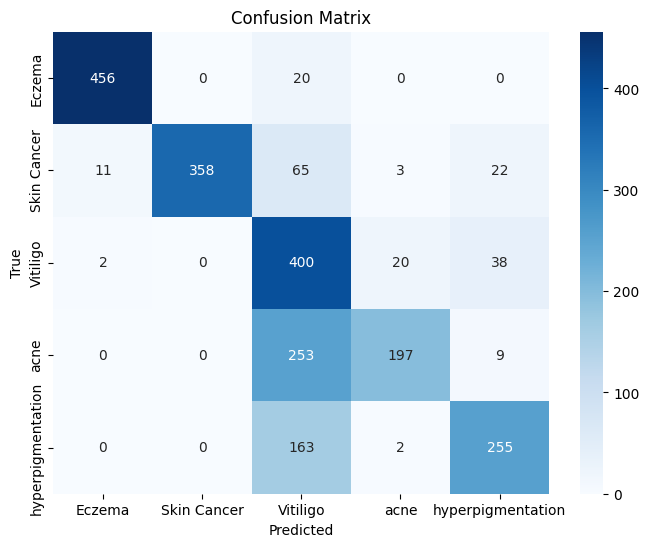

In [11]:
cm = confusion_matrix(val_true, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<!--loss: 0.3170 - accuracy: 0.8803 - val_loss: 0.7136 - val_accuracy: 0.7388 - lr: 2.0000e-06 -->

In [12]:
from tensorflow.keras.preprocessing import image

In [24]:
img_path =r"D:\my notebook\AIH\vit.jpeg"
img = image.load_img(img_path,target_size=(224 , 224))
x = image.img_to_array(img)
x = x/255.0
x = np.expand_dims(x, axis=0)

In [25]:
preds = model.predict(x)
print("Predicted:",preds)

1/1 [==============================] - 0s 56ms/step
Predicted: [[2.0288301e-03 2.6155653e-12 9.9795306e-01 1.0187830e-05 7.8466337e-06]]


In [27]:
import numpy as np

# Get index of highest probability

predicted_class_index = np.argmax(preds)
# Get class name
predicted_class_name = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_name)


Predicted class: Vitiligo


In [28]:
model.save("resnet50_classifier.h5")

In [29]:
print(train_generator.class_indices)
print(train_generator.samples)


{'Eczema': 0, 'Skin Cancer': 1, 'Vitiligo': 2, 'acne': 3, 'hyperpigmentation': 4}
9108
